In [2]:
# Import necessary libraries
import pyreadr
import pandas as pd
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()
from rpy2.robjects.conversion import localconverter
import plotly.graph_objects as go
import numpy as np
import streamlit as st
from pycirclize import Circos
import matplotlib.pyplot as plt
import seaborn as sns
import liana as li
import scanpy as sc
from anndata import AnnData
import pandas as pd
from liana.mt import rank_aggregate
from liana.method import singlecellsignalr, connectome, cellphonedb, natmi, logfc, cellchat, geometric_mean

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
control_male_24weeks = sc.read_h5ad('../exported_data/pvat_24weeks_control_male.h5ad')
control_male_24weeks

AnnData object with n_obs × n_vars = 11457 × 20743
    obs: 'sample_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'n_genes', 'scDblFinder_score', 'scDblFinder_class', 'Sample', 'tissue', 'diet', 'time', 'sex', 'batch', 'sample_type', 'rat_id', 'weight_3W', 'weight_10W', 'weight_17W', 'weight_24W', 'MAP_7W', 'systolic_bp_7W', 'MAP_9W', 'systolic_bp_9W', 'MAP_16W', 'systolic_bp_16W', 'MAP_24W', 'systolic_bp_24W', 'doublet', 'celltype', 'celltype_broad'
    var: 'gene_ids', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'cellchat_interaction_table_count', 'cellchat_res', 'cellchat_res_filtered',

In [4]:
np.unique(control_male_24weeks.obs['celltype_broad'])

array(['Adipocytes', 'Endothelial_Cells', 'Fibroblasts', 'Immune_Cells',
       'Mesothelial_Cells', 'Neuronal_Cells', 'Pericytes', 'SMCs'],
      dtype=object)

In [12]:
# Load RDS file using rpy2, needed for interaction data
filepath = '../figures/exported_results/nichenet/pvat_24weeks_control_male_nichenet.rds'
readRDS = ro.r['readRDS']
pvat_cci = readRDS(filepath)

In [13]:
source_labels = ['Adipocytes', 'Endothelial_Cells', 'Fibroblasts', 'Immune_Cells',
       'Mesothelial_Cells', 'Neuronal_Cells', 'Pericytes', 'SMCs']
target_labels = ['Adipocytes', 'Endothelial_Cells', 'Fibroblasts', 'Immune_Cells',
       'Mesothelial_Cells', 'Neuronal_Cells', 'Pericytes', 'SMCs']

In [14]:
cell_pair_interactions = []
for source_cell in source_labels:
    for target_cell in target_labels:
            cell_pair_string = f'{source_cell.replace(" ", "")}2{target_cell.replace(" ", "")}'
            cell_one2cell_two = pvat_cci.rx2(cell_pair_string)
            ligand_receptor = pandas2ri.rpy2py(cell_one2cell_two.rx2('p_ligand_receptor_network'))
            long_format = ligand_receptor.T.stack().reset_index().set_axis('ligand_complex receptor_complex weight'.split(), axis=1)
            long_format['source'] = source_cell
            long_format['target'] = target_cell
        
            cell_pair_interactions.append(long_format)

nichenet_cci = pd.concat(cell_pair_interactions)

In [15]:
nichenet_cci = nichenet_cci[nichenet_cci['weight']>0]
nichenet_cci

,ligand_complex,receptor_complex,weight,source,target
13,Ltbp3,Itgb5,0.385908,Adipocytes,Adipocytes
62,Serpine1,Itgav,0.515901,Adipocytes,Adipocytes
63,Serpine1,Itgb5,0.484110,Adipocytes,Adipocytes
98,Serpine1,Lrp1,0.863215,Adipocytes,Adipocytes
108,Igf1,Igf1r,1.464502,Adipocytes,Adipocytes
...,...,...,...,...,...
6043,Lama5,Itga3,0.934487,SMCs,SMCs
6046,Lama5,Bcam,0.595226,SMCs,SMCs
6047,Lama5,Dag1,0.928908,SMCs,SMCs
6080,Lamb2,Itgb1,0.666722,SMCs,SMCs


In [16]:
nichenet_cci
control_male_24weeks.uns['nichenet_lr_res'] = nichenet_cci

In [17]:
#control_male_24weeks.write('../exported_data/pvat_24weeks_control_male.h5ad')

## NichetNet Plots

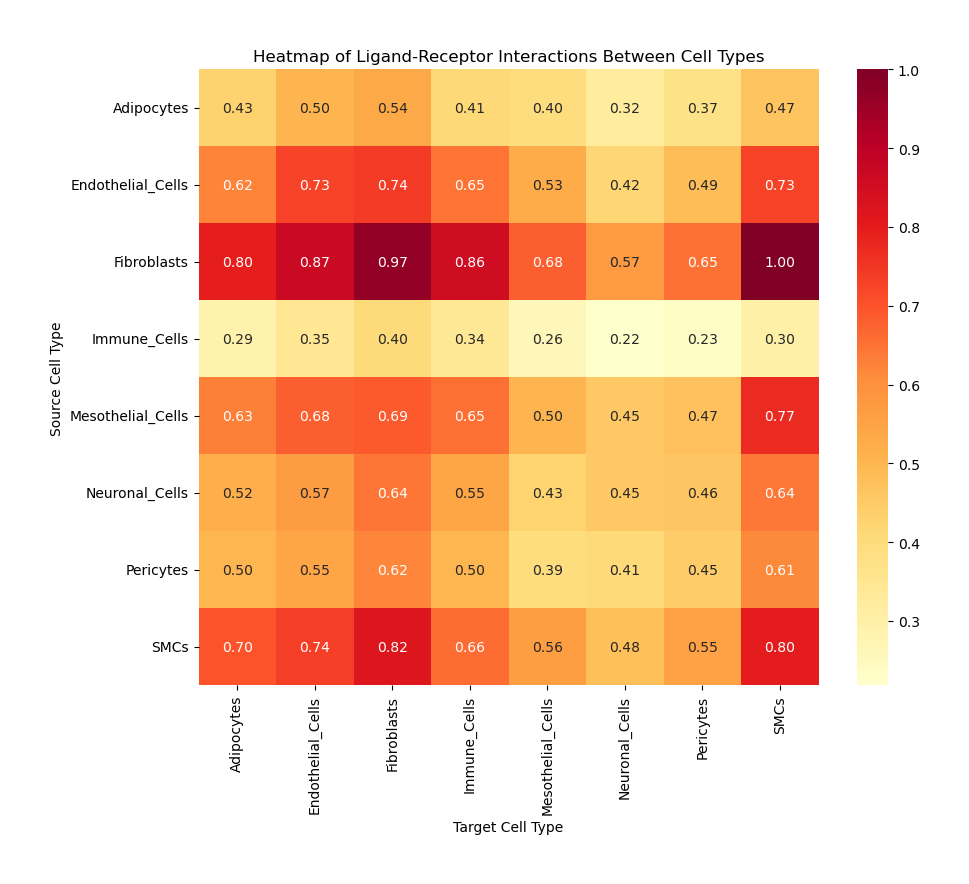

In [18]:
interaction_pivot_table_nichenet = control_male_24weeks.uns['nichenet_lr_res'].groupby(['source', 'target', 'ligand_complex', 'receptor_complex']).size().groupby(['source', 'target']).sum().unstack(fill_value=0)
interaction_pivot_table_nichenet_norm = interaction_pivot_table_nichenet / interaction_pivot_table_nichenet.max().max()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(interaction_pivot_table_nichenet_norm, annot=True, cmap="YlOrRd", fmt=".2f", ax=ax)
ax.set_title('Heatmap of Ligand-Receptor Interactions Between Cell Types')
ax.set_ylabel('Source Cell Type')
ax.set_xlabel('Target Cell Type')
plt.show()

In [19]:
control_male_24weeks.uns['nichenet_interaction_table_count'] = interaction_pivot_table_nichenet

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


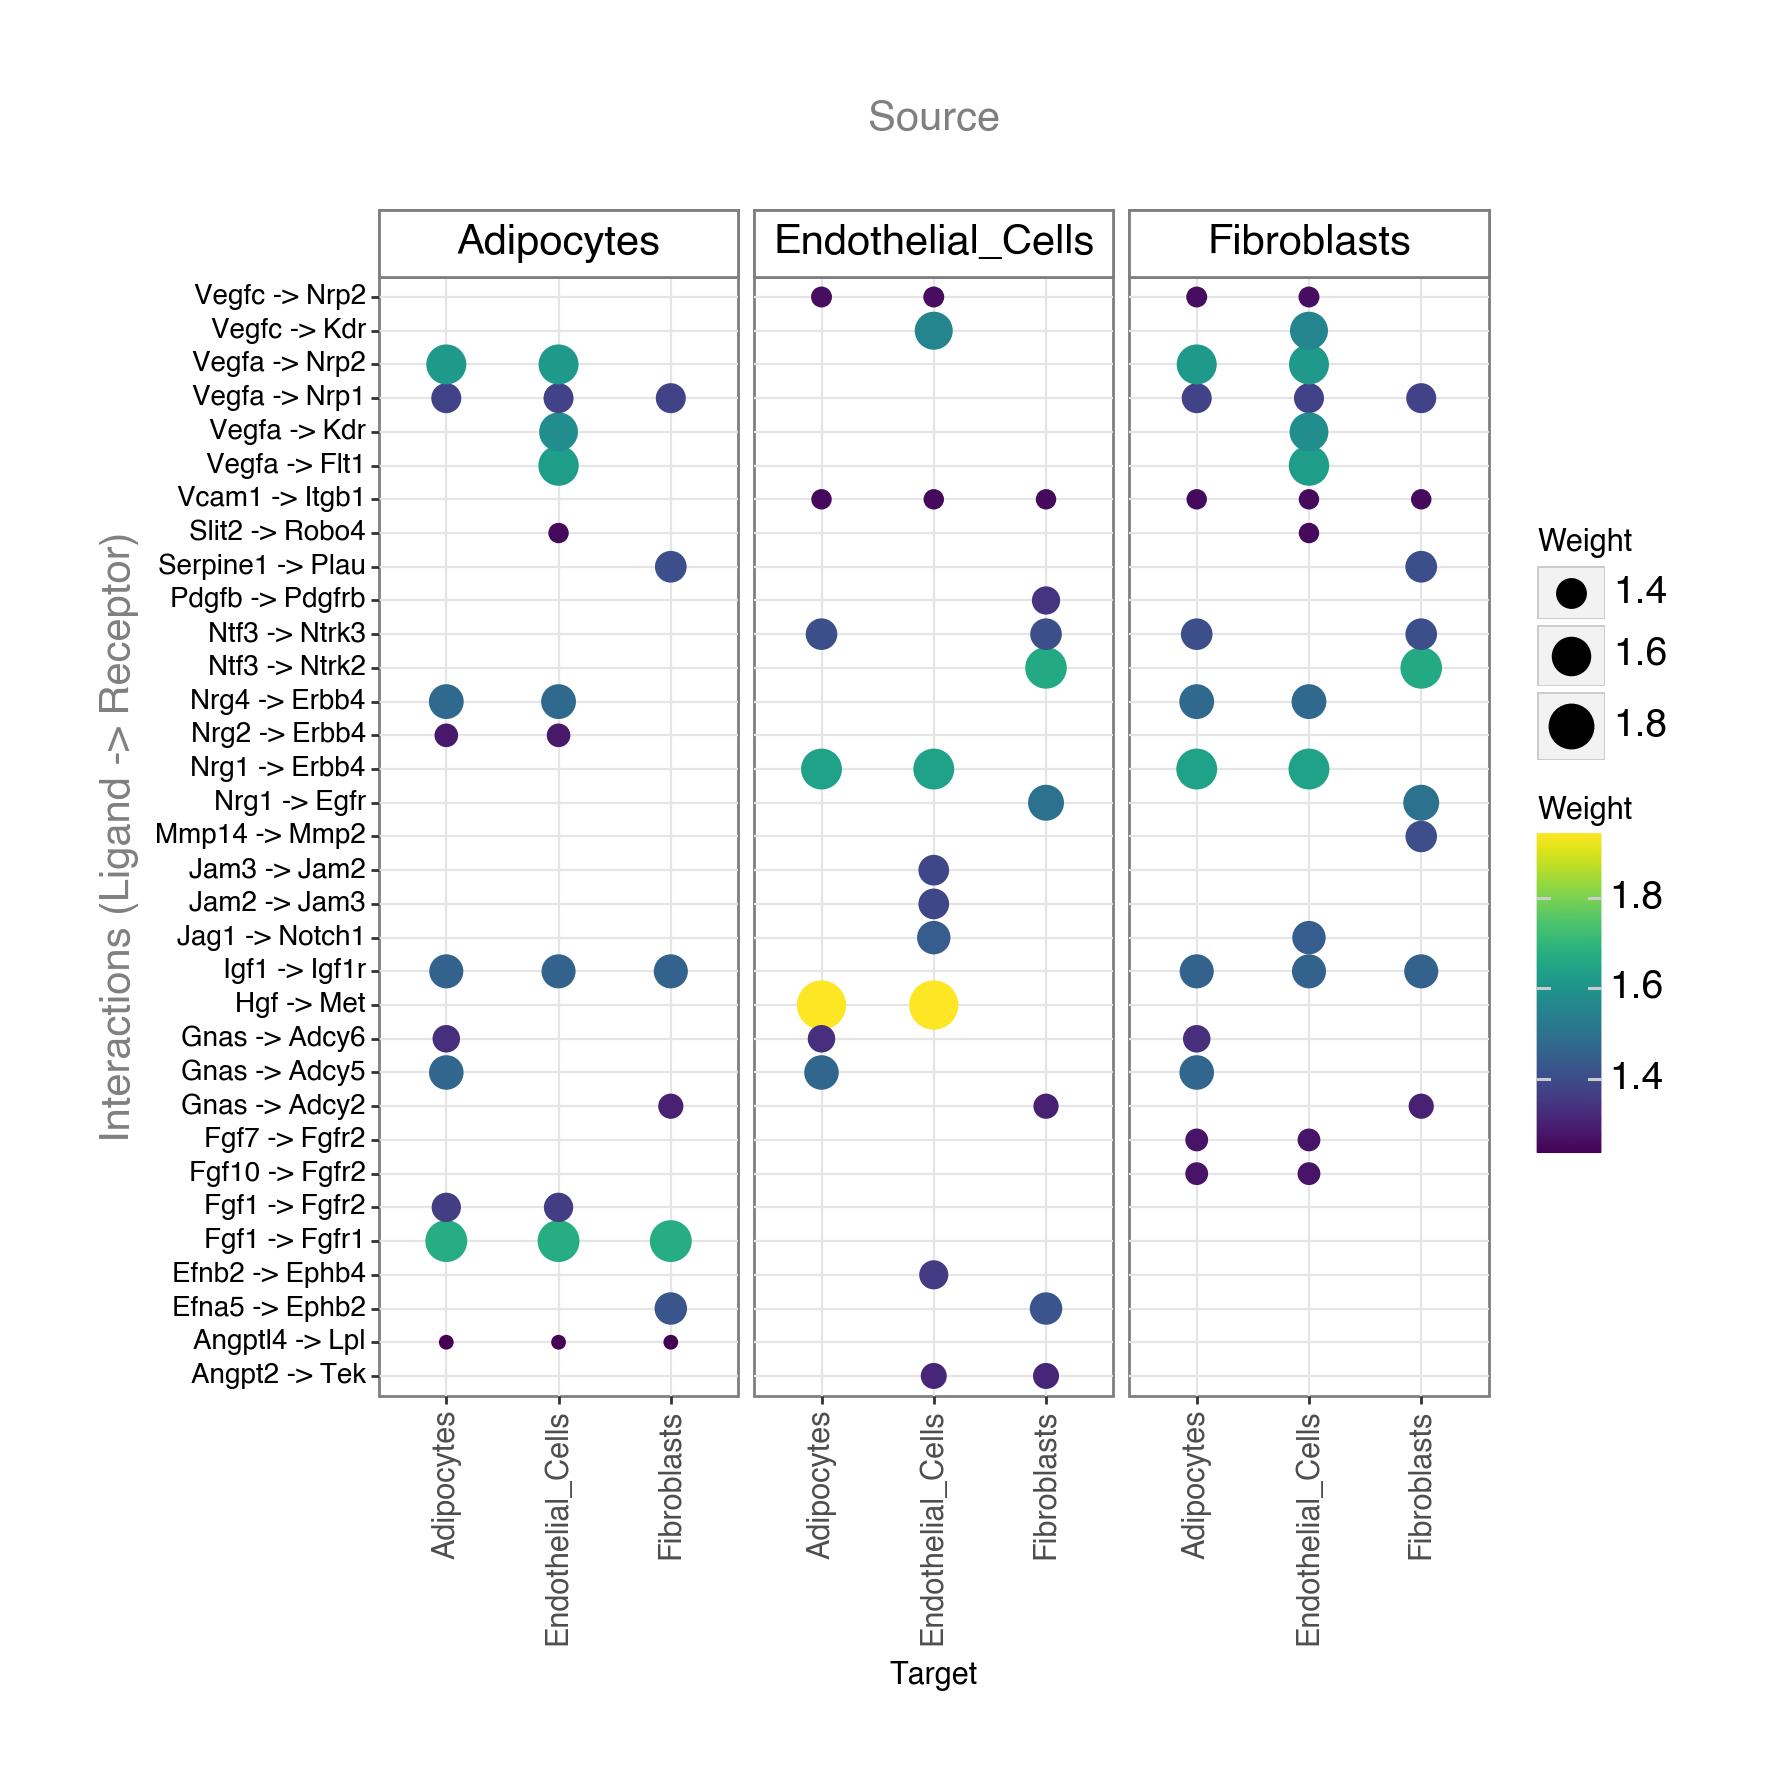

<Figure Size: (800 x 800)>

In [13]:
nichenet_df = control_male_24weeks.uns['nichenet_lr_res']
control_male_24weeks.uns['nichenet_res_filtered'] = nichenet_df[nichenet_df['weight']>1.25]
nichenet_plot = li.pl.dotplot(adata = control_male_24weeks,
              colour='weight',
              size='weight',
              source_labels=['Adipocytes', 'Endothelial_Cells', 'Fibroblasts'],
              target_labels=['Adipocytes', 'Endothelial_Cells', 'Fibroblasts'],
              figure_size=(8, 8),
              uns_key='nichenet_res_filtered' # uns_key to use, default is 'liana_res'
             )
nichenet_plot

## CellChat

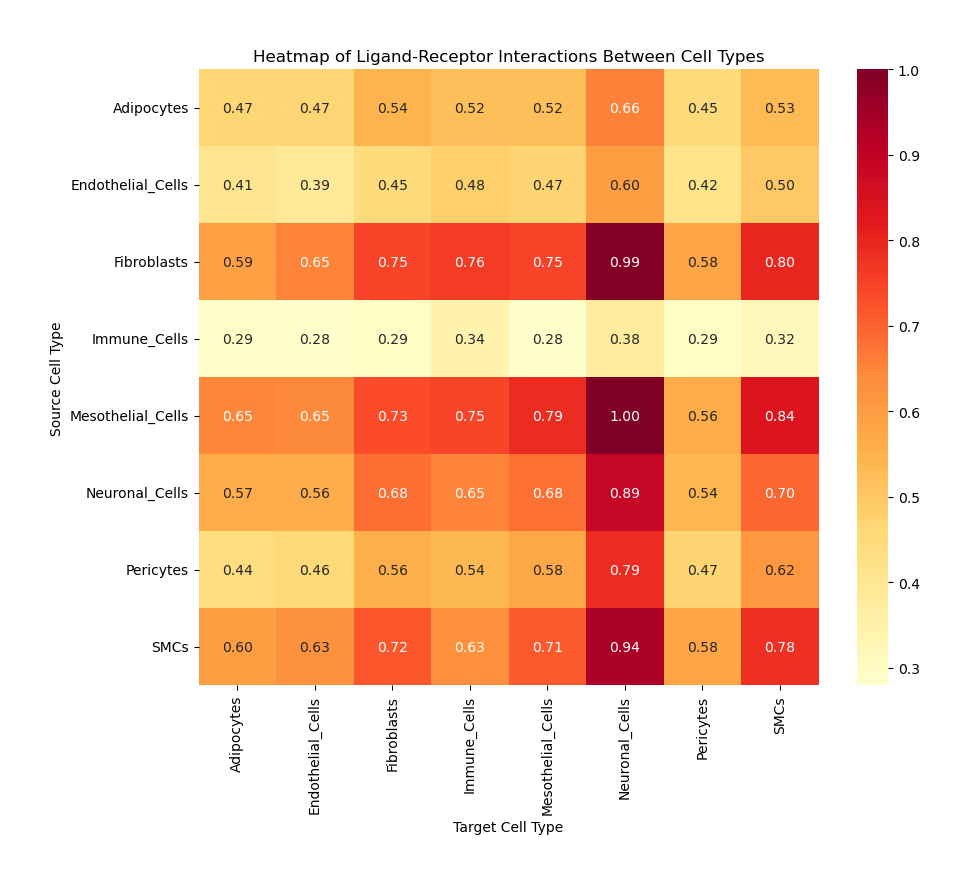

In [20]:
interaction_pivot_table_cellchat = control_male_24weeks.uns['cellchat_res'].groupby(['source', 'target', 'ligand_complex', 'receptor_complex']).size().groupby(['source', 'target']).sum().unstack(fill_value=0)
interaction_pivot_table_cellchat_norm = interaction_pivot_table_cellchat / interaction_pivot_table_cellchat.max().max()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(interaction_pivot_table_cellchat_norm, annot=True, cmap="YlOrRd", fmt=".2f", ax=ax)
ax.set_title('Heatmap of Ligand-Receptor Interactions Between Cell Types')
ax.set_ylabel('Source Cell Type')
ax.set_xlabel('Target Cell Type')
plt.show()

In [21]:
control_male_24weeks.uns['cellchat_interaction_table_count'] = interaction_pivot_table_cellchat

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


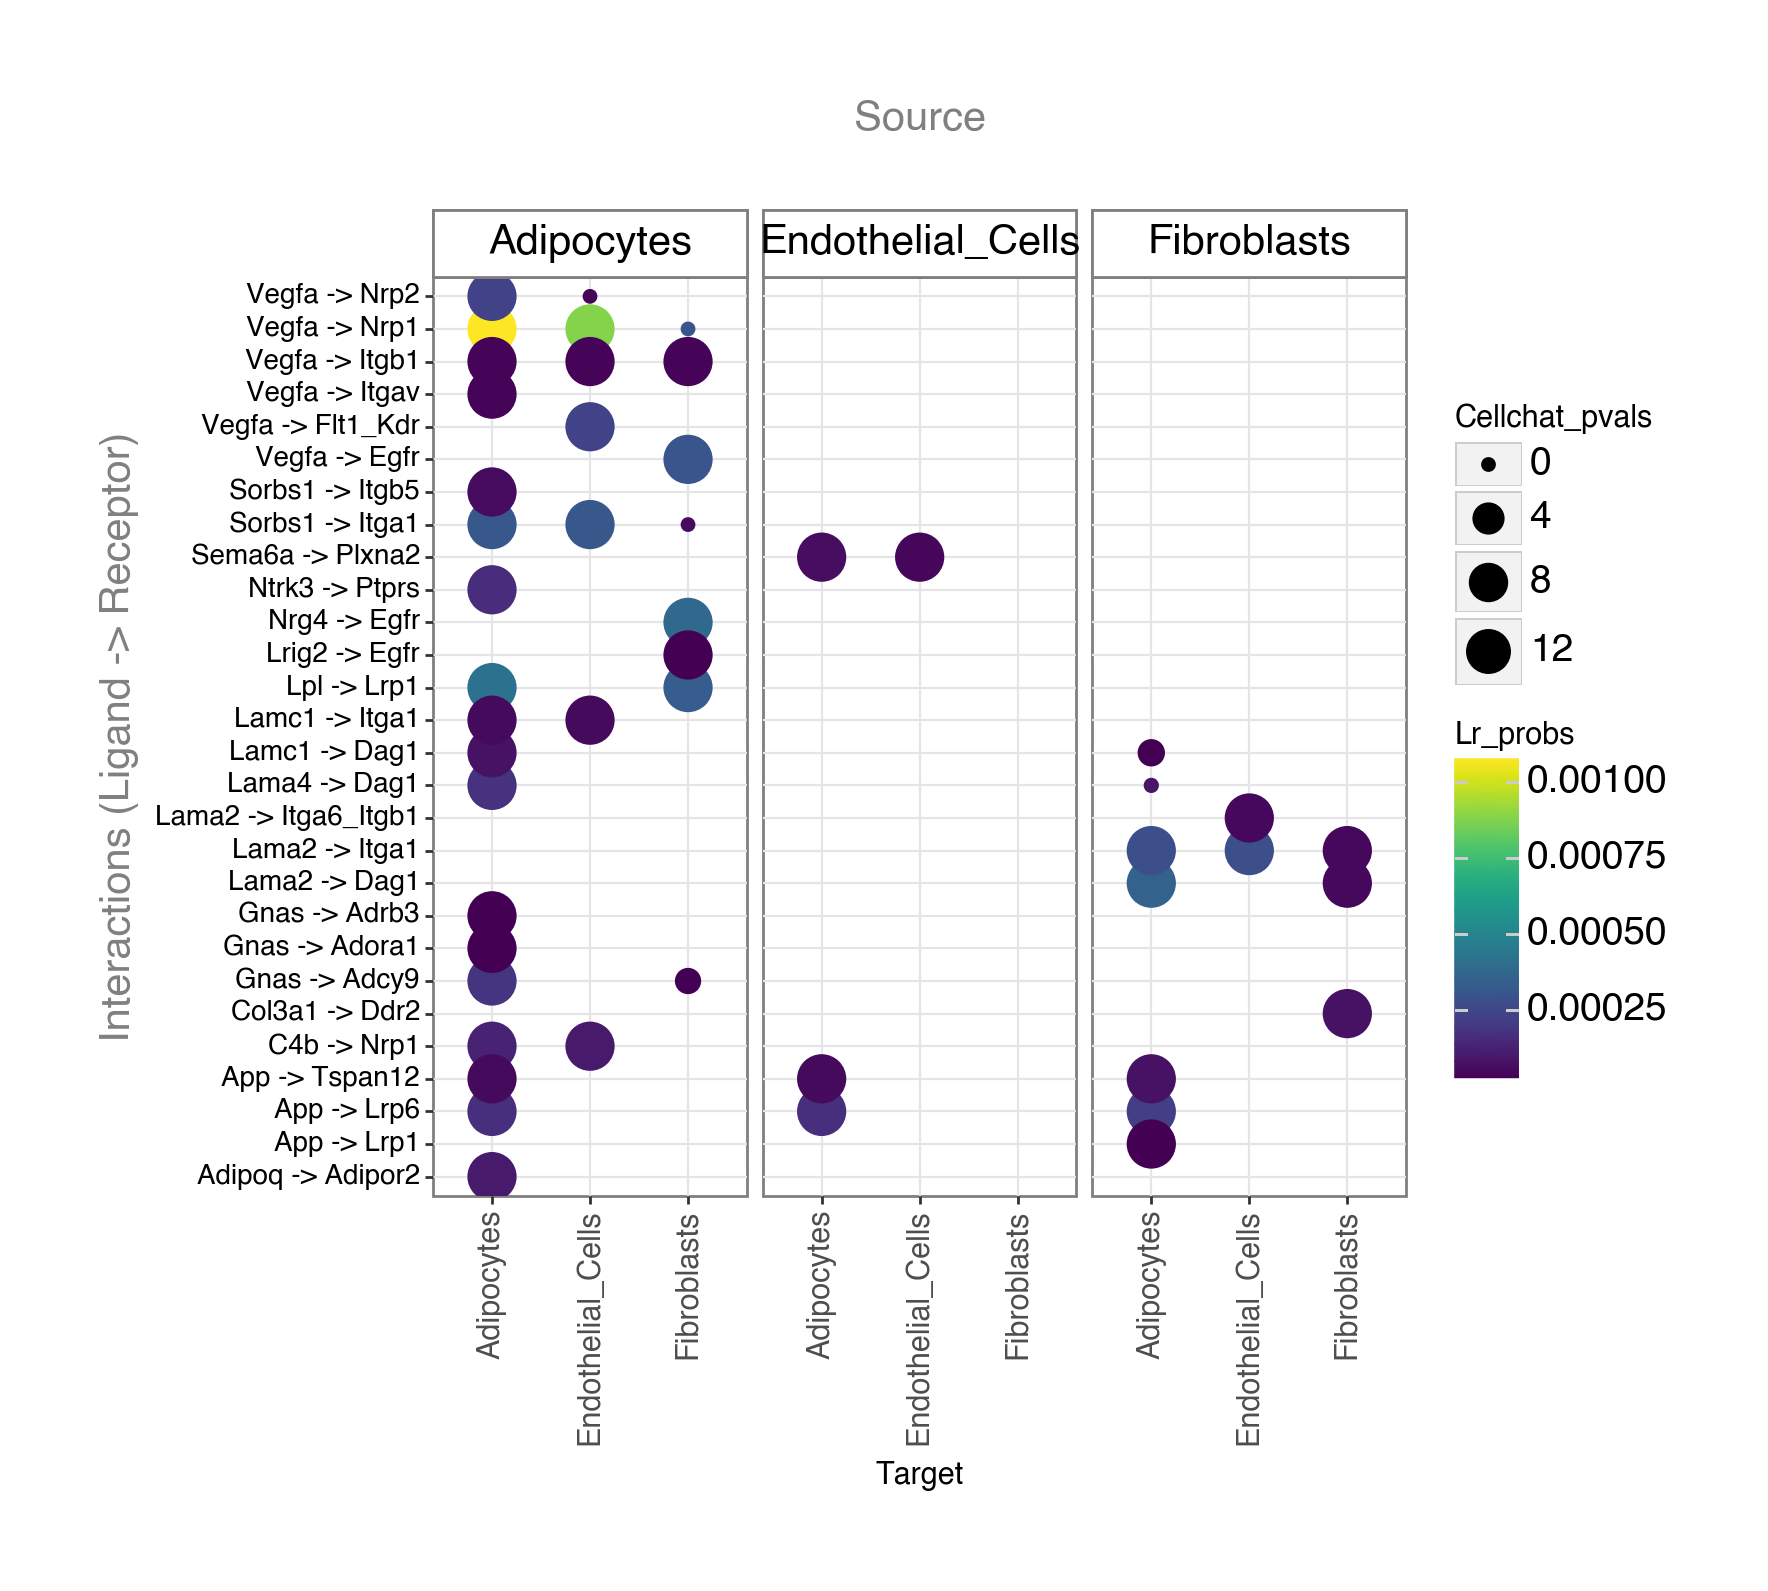

<Figure Size: (800 x 700)>

In [16]:
cellchat_df = control_male_24weeks.uns['cellchat_res']
control_male_24weeks.uns['cellchat_res_filtered'] = cellchat_df[cellchat_df['lr_probs']>0.00005]
cellchat_plot = li.pl.dotplot(adata = control_male_24weeks,
              colour='lr_probs',
              size='cellchat_pvals',
              inverse_size=True, # we inverse sign since we want small p-values to have large sizes
              source_labels=['Adipocytes', 'Endothelial_Cells', 'Fibroblasts'],
              target_labels=['Adipocytes', 'Endothelial_Cells', 'Fibroblasts'],
              figure_size=(8, 7),
              # we filter the pvals column to <= 0.05
              filter_fun=lambda x: x['cellchat_pvals'] <= 0.05,
              uns_key='cellchat_res_filtered' # uns_key to use, default is 'liana_res'
             )
cellchat_plot

## CellPhonedb

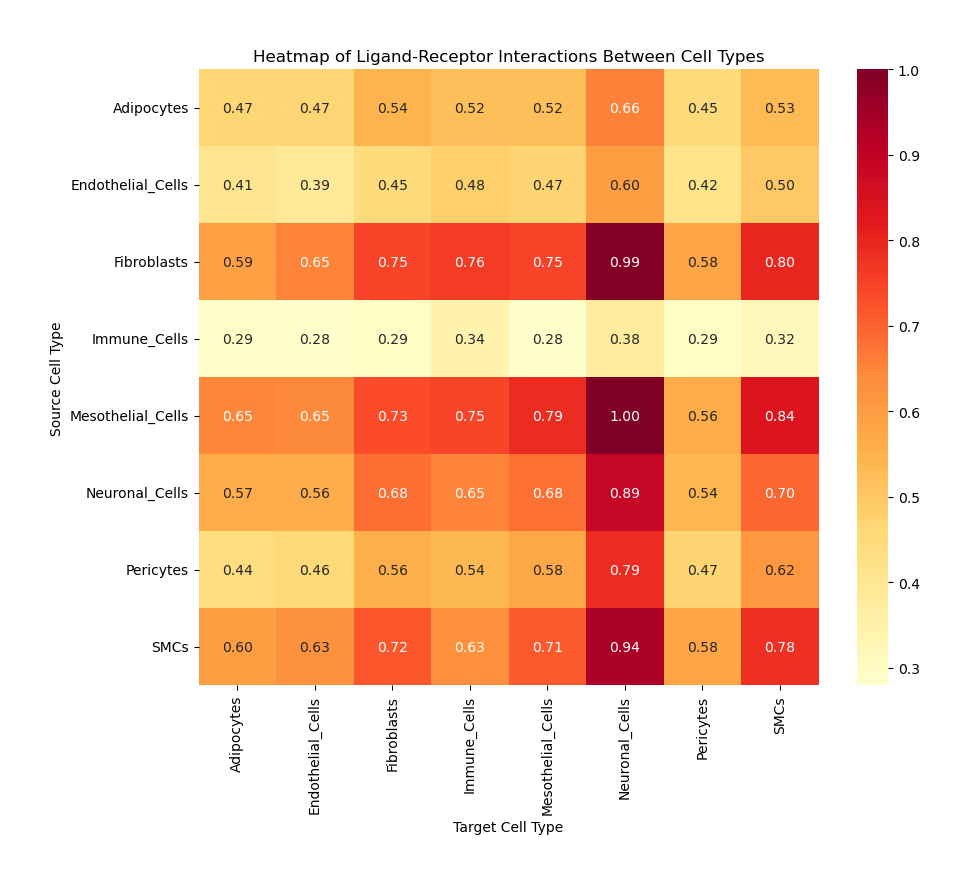

In [22]:
interaction_pivot_table_cellphonedb = control_male_24weeks.uns['cellphonedb_res'].groupby(['source', 'target', 'ligand_complex', 'receptor_complex']).size().groupby(['source', 'target']).sum().unstack(fill_value=0)
interaction_pivot_table_cellphonedb_norm = interaction_pivot_table_cellphonedb / interaction_pivot_table_cellphonedb.max().max()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(interaction_pivot_table_cellphonedb_norm, annot=True, cmap="YlOrRd", fmt=".2f", ax=ax)
ax.set_title('Heatmap of Ligand-Receptor Interactions Between Cell Types')
ax.set_ylabel('Source Cell Type')
ax.set_xlabel('Target Cell Type')
plt.show()

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


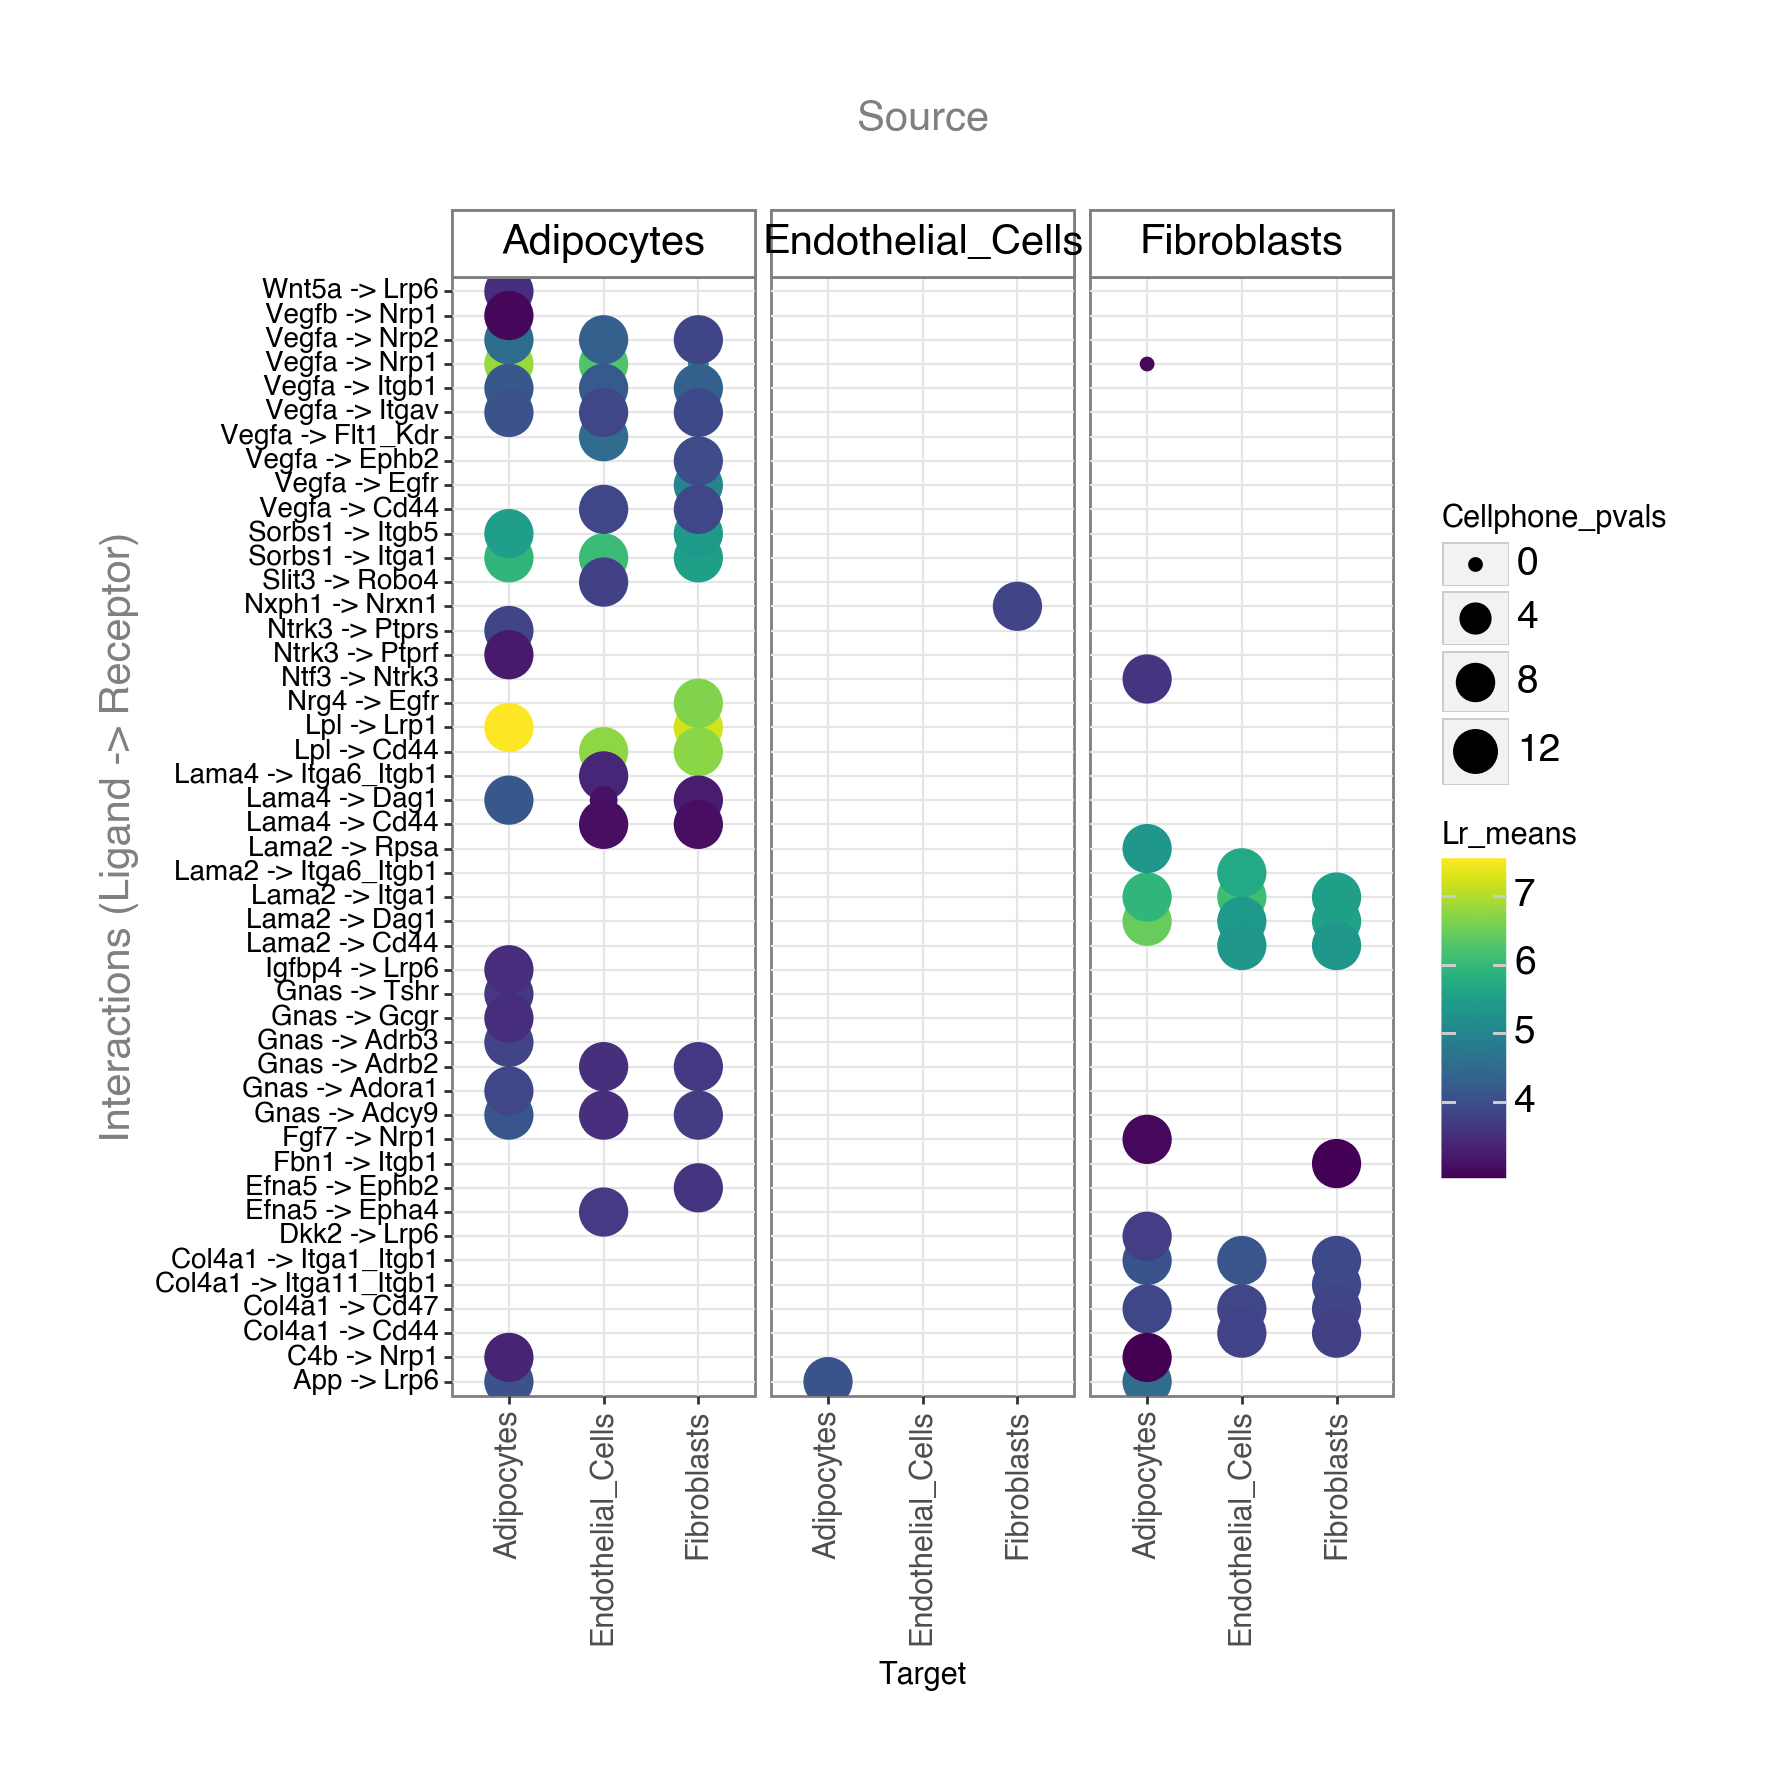

<Figure Size: (800 x 800)>

In [18]:
cellphonedb_db = control_male_24weeks.uns['cellphonedb_res']
control_male_24weeks.uns['cellphonedb_res_filtered'] = cellphonedb_db[cellphonedb_db['lr_means']>3]

li.pl.dotplot(adata = control_male_24weeks,
              colour='lr_means',
              size='cellphone_pvals',
              inverse_size=True, # we inverse sign since we want small p-values to have large sizes
              source_labels=['Adipocytes', 'Endothelial_Cells', 'Fibroblasts'],
              target_labels=['Adipocytes', 'Endothelial_Cells', 'Fibroblasts'],
              figure_size=(8, 8),
              # we filter the pvals column to <= 0.05
              filter_fun=lambda x: x['cellphone_pvals'] <= 0.05,
              uns_key='cellphonedb_res_filtered' # uns_key to use, default is 'liana_res'
             )

In [23]:
control_male_24weeks.uns['cellphonedb_interaction_table_count'] = interaction_pivot_table_cellphonedb

In [24]:
control_male_24weeks.write('../exported_data/pvat_24weeks_control_male.h5ad')